In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'


import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import pickle
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Scoring difference

In [9]:
scores_path = f'{RESULT_TABLE}/MPs/Tumor/signature_scores.csv'
obs_path = f'{RESULT_TABLE}/GEX_OBS.csv'
with open(f'{RESULT_TABLE}/MPs/Tumor/MP_anno_map.pickle', "rb") as input_file:
    MP_anno_map= pickle.load(input_file)
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0])
obs = pd.read_csv(obs_path,index_col=0)
obs = obs.loc[obs.Lineage=='Tumor',:]
# attach clinical information
scores = scores.merge(obs,left_index=True,right_index=True,how='left')

## Baseline prediction

In [17]:
x='BestResponse'
explored_z='Treatment_Arm'
random_var='Patient'
dt = scores.loc[scores.Timepoint=='Baseline',:].copy()
dt.groupby([explored_z,x])[random_var].nunique().rename('N_Pts').reset_index()

,Treatment_Arm,BestResponse,N_Pts
0,Chemo->Combo,0-I,1
1,Chemo->Combo,II-III,3
2,ICI->Combo,0-I,2
3,ICI->Combo,II-III,6


In [18]:
dt[x] = pd.Categorical(dt[x],['II-III','0-I'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[explored_z],explored_z=explored_z,random_var=random_var)
result.Y = result.Y.map(MP_anno_map)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>1)&(result.Treatment_Arm=='Chemo->ICI+ICI->Chemo')].unique().tolist()
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,Treatment_Arm,FDR
0,II-III,0-I,Apelin,-0.587609,-1.703567,0.05530879709857246,ICI->Combo,0.124445
0,II-III,0-I,Apelin,-0.796426,-1.703567,0.3487303552632607,Chemo->Combo,0.784643
0,II-III,0-I,Apelin,-0.656097,-1.703567,0.03405235750036691,Chemo->Combo+ICI->Combo,0.079024
0,II-III,0-I,EMT-I,-0.052336,-1.448277,0.904686188486787,Chemo->Combo+ICI->Combo,0.904686
0,II-III,0-I,EMT-I,0.033053,-1.448277,0.895745699465102,Chemo->Combo,0.922181
0,II-III,0-I,EMT-I,-0.097488,-1.448277,0.8794078756189703,ICI->Combo,0.879408
0,II-III,0-I,ER-II,-0.447926,-0.648596,0.12484532597816109,ICI->Combo,0.224722
0,II-III,0-I,ER-II,-0.456972,-0.648596,0.02422679053366345,Chemo->Combo+ICI->Combo,0.079024
0,II-III,0-I,ER-II,-0.474627,-0.648596,0.017365233458798826,Chemo->Combo,0.052096
0,II-III,0-I,Stress,-0.206005,-0.471487,0.24513578468924951,Chemo->Combo+ICI->Combo,0.367704


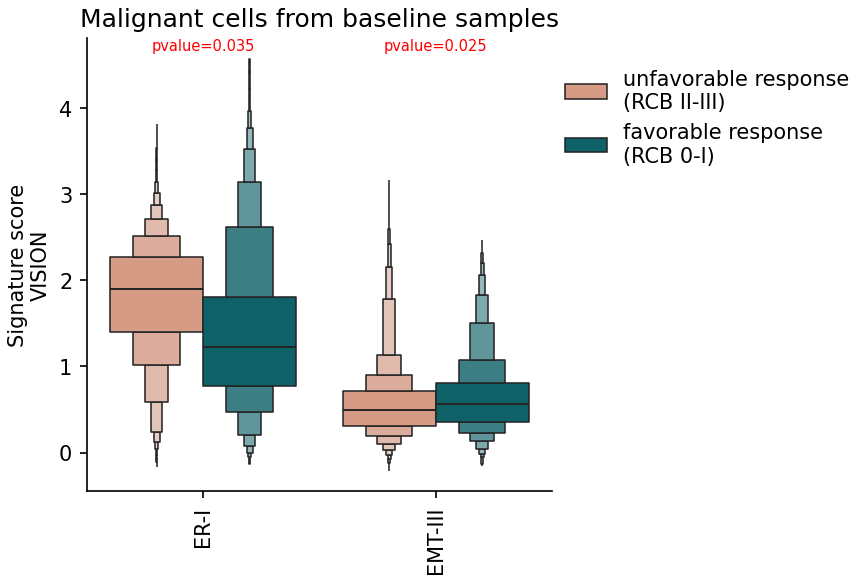

In [19]:
show_mps = ['ER-I','EMT-III']
pvalues = result.loc[(result.Y.isin(show_mps))&
                     (result.Treatment_Arm=='Chemo->Combo+ICI->Combo'),:].set_index('Y')['Pvalue']
fig,ax=plt.subplots(1,1,dpi=150,figsize=(4,4))
dt.BestResponse = dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
sns.boxenplot(data=dt.rename(columns=MP_anno_map)[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   showfliers=False,
#                 split=True,inner="quart", fill=False,
                palette=COLOR_PAlETTE[x])
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = 'N.S.' 
    else:
        label = f"pvalue={pvalues[text]:.3f}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
ax.tick_params(axis='x',rotation=90)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='',ylabel=f'Signature score\n{signature_method}',title=f'Malignant cells from baseline samples')# [{n_pt_label}]')
# ax.set_xticklabels([ MP_anno_map[x.get_text()] for x in ax.get_xticklabels()]);
ax.legend(loc=(1.01,.7),frameon=False,ncol=1)

## Paired pt timepoint- treatment induced effect difference

### Chemo lead-in

In [42]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W3D1'])&
                scores.Treatment_Arm.isin(['Chemo->Combo']),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,2
1,W3D1,2


In [43]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W3D1,EMT-I,-0.158723,-1.50327,2.0146563060552426e-26,0.0
0,Baseline,W3D1,Cell_Cycle,-0.027864,-0.138165,0.20662049940634344,0.265655
0,Baseline,W3D1,ER-I,-0.003823,-0.038195,0.8748842303335301,0.97985
0,Baseline,W3D1,Stress,-0.000273,0.043319,0.9798498763854643,0.97985
0,Baseline,W3D1,EMT-II,0.088184,0.067304,4.1657046120987466e-07,0.000001
0,Baseline,W3D1,Apelin,0.102281,0.356656,3.094841939817241e-38,0.0
0,Baseline,W3D1,EMT-III,0.192947,0.428062,1.7659205954663977e-96,0.0
0,Baseline,W3D1,ER-II,0.23298,0.468654,2.2577744453926055e-124,0.0
0,Baseline,W3D1,Interferon/MHCII(I),0.770832,1.067326,1.6237015912729883e-261,0.0


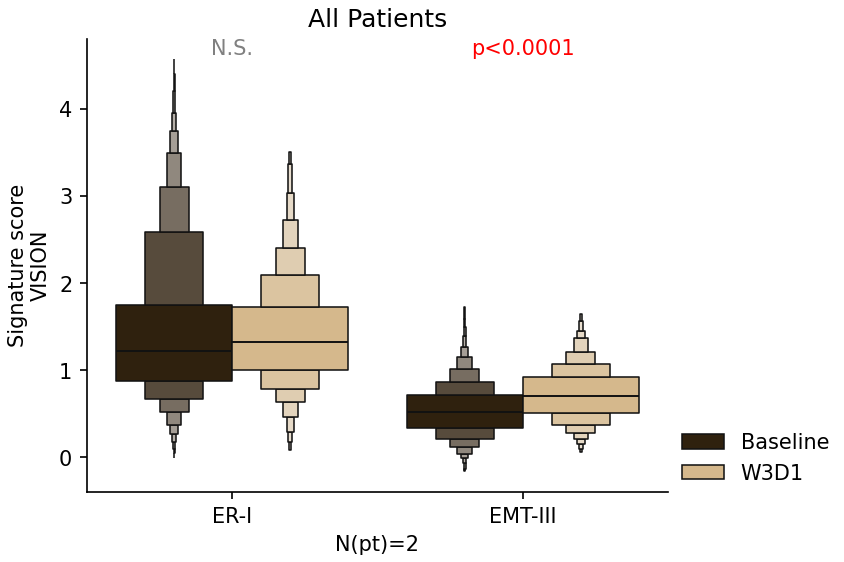

In [44]:
show_mps = ['ER-I','EMT-III']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=COLOR_PAlETTE[x],ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = 'N.S.' 
    elif pvalues[text]<0.0001:
        label = f"p<0.0001"
        c = 'red'
    else:
        label = f"p={pvalues[text]:.3e}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='All Patients')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)

### ICI lead in

In [46]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W3D1'])&
                scores.Treatment_Arm.isin(['ICI->Combo']),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,3
1,W3D1,3


In [47]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W3D1,Stress,-0.26367,-0.878942,0.0,0.0
0,Baseline,W3D1,EMT-I,-0.172371,-0.567386,4.2544674987456075e-104,0.0
0,Baseline,W3D1,ER-II,0.008846,-0.024381,0.10554348671324407,0.105543
0,Baseline,W3D1,Apelin,0.085891,0.052592,1.3142562054873625e-19,0.0
0,Baseline,W3D1,EMT-III,0.028157,0.083831,4.778467638577704e-09,0.0
0,Baseline,W3D1,Cell_Cycle,0.02619,0.169021,0.011539917540921837,0.012982
0,Baseline,W3D1,ER-I,0.505686,0.274672,0.0,0.0
0,Baseline,W3D1,EMT-II,0.236956,0.350925,1.8370944539296274e-258,0.0
0,Baseline,W3D1,Interferon/MHCII(I),0.034413,0.446814,9.719994422259059e-08,0.0


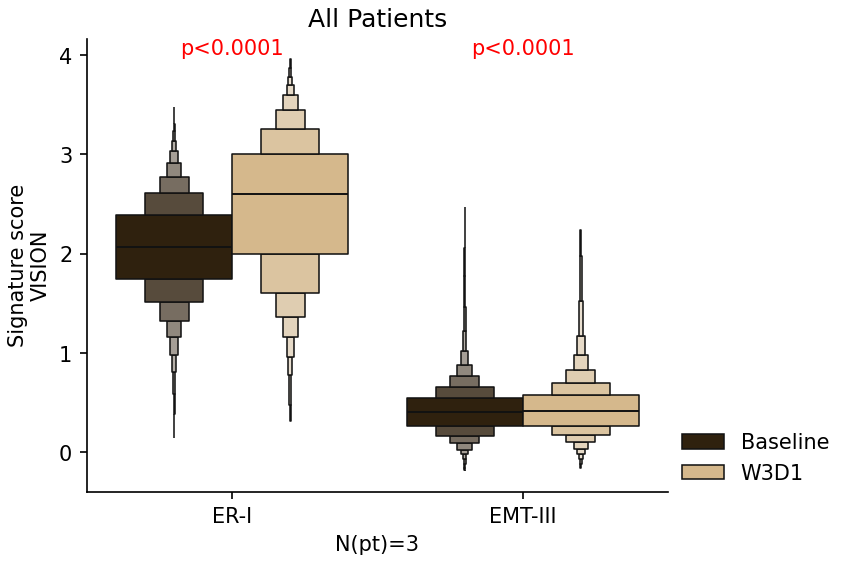

In [48]:
show_mps = ['ER-I','EMT-III']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=COLOR_PAlETTE[x],ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = 'N.S.' 
    elif pvalues[text]<0.0001:
        label = f"p<0.0001"
        c = 'red'
    else:
        label = f"p={pvalues[text]:.3e}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='All Patients')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)

## Paired pt timepoint- resistant tumor states

### In all patients

In [30]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1']),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,5
1,W7D1,5


In [31]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W7D1,EMT-II,-0.18521,-0.561382,1.2558063231763366e-65,0.0
0,Baseline,W7D1,Cell_Cycle,-0.131816,-0.437706,3.875840273448841e-16,0.0
0,Baseline,W7D1,EMT-III,-0.016649,-0.397356,0.0314516270095343,0.031452
0,Baseline,W7D1,ER-I,-0.160461,-0.039249,6.602979562258884e-32,0.0
0,Baseline,W7D1,ER-II,-0.105901,-0.026305,3.224006691150698e-57,0.0
0,Baseline,W7D1,EMT-I,-0.140748,0.047393,5.320493498423467e-26,0.0
0,Baseline,W7D1,Interferon/MHCII(I),0.072537,0.206797,3.3385083188334954e-06,0.000004
0,Baseline,W7D1,Stress,0.177051,0.25739,2.869828750672107e-73,0.0
0,Baseline,W7D1,Apelin,0.115812,0.733668,3.5347738583918274e-35,0.0


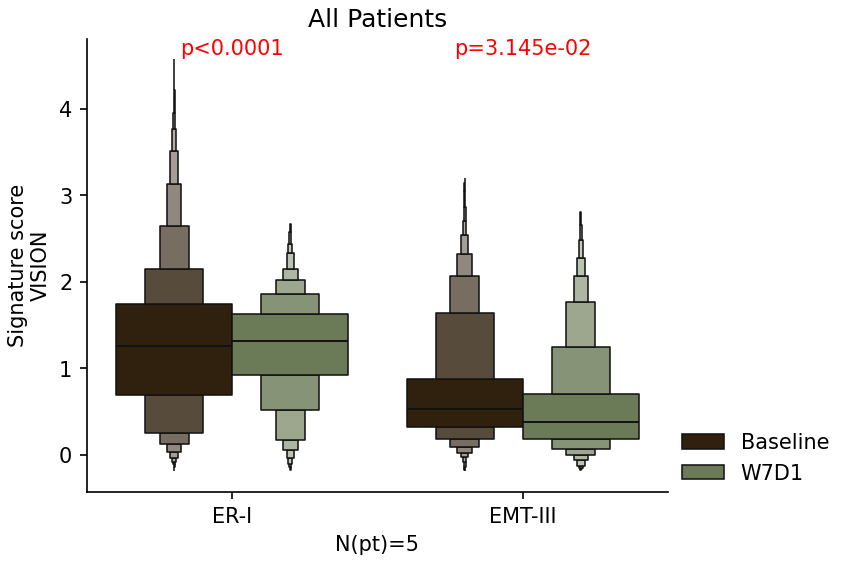

In [32]:
show_mps = ['ER-I','EMT-III']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=COLOR_PAlETTE[x],ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = 'N.S.' 
    elif pvalues[text]<0.0001:
        label = f"p<0.0001"
        c = 'red'
    else:
        label = f"p={pvalues[text]:.3e}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='All Patients')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)

### In Responders

In [33]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1'])&
                (scores.BestResponse=='0-I'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,2
1,W7D1,2


In [34]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W7D1,Cell_Cycle,-0.357361,-1.189375,2.5313610522396987e-14,0.0
0,Baseline,W7D1,ER-I,-0.414907,-0.45682,5.080784128974837e-16,0.0
0,Baseline,W7D1,ER-II,0.02977,0.085889,0.08428639053674224,0.084286
0,Baseline,W7D1,Apelin,0.056241,0.212205,0.00032320549466392074,0.000416
0,Baseline,W7D1,EMT-III,0.155643,0.257635,4.006143329705676e-15,0.0
0,Baseline,W7D1,EMT-I,0.088608,0.336532,0.0014654982435292597,0.001649
0,Baseline,W7D1,EMT-II,0.458774,0.458519,1.0977907588084615e-39,0.0
0,Baseline,W7D1,Interferon/MHCII(I),1.199667,1.38769,2.0384229075567155e-161,0.0
0,Baseline,W7D1,Stress,1.88251,2.310378,0.0,0.0


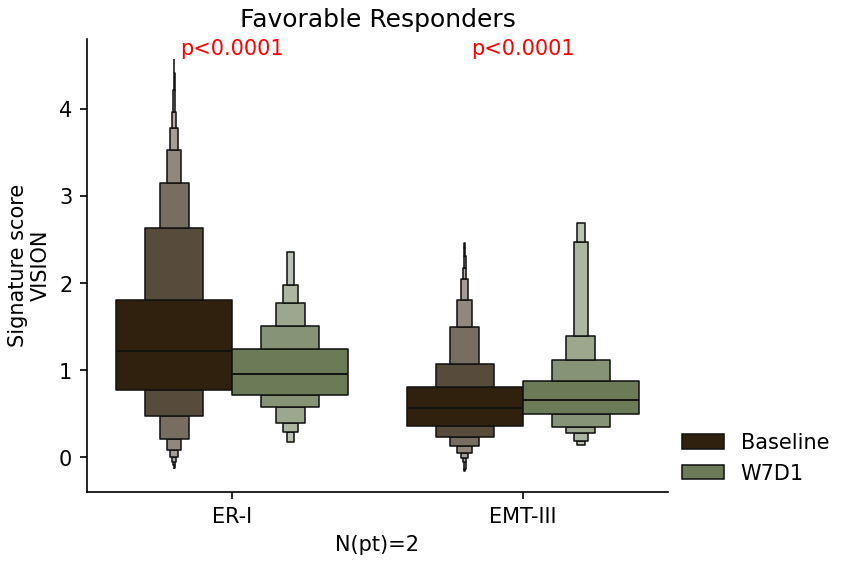

In [35]:
show_mps = ['ER-I','EMT-III']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=COLOR_PAlETTE[x],ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = 'N.S.' 
    elif pvalues[text]<0.0001:
        label = f"p<0.0001"
        c = 'red'
    else:
        label = f"p={pvalues[text]:.3e}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Favorable Responders')
# ax.set_xticklabels([])
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);

### In Unfavorable responder

In [36]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1'])&
                (scores.BestResponse=='II-III'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,3
1,W7D1,3


In [37]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W7D1,EMT-II,-0.286948,-0.610497,3.7809332993310924e-203,0.0
0,Baseline,W7D1,EMT-III,-0.043918,-0.610472,2.9170300335758373e-07,0.0
0,Baseline,W7D1,EMT-I,-0.177205,-0.418293,3.615856039248164e-28,0.0
0,Baseline,W7D1,Stress,-0.092886,-0.338934,2.2776499377528958e-35,0.0
0,Baseline,W7D1,Cell_Cycle,-0.095737,-0.180962,7.018495124512644e-09,0.0
0,Baseline,W7D1,ER-II,-0.127412,-0.133862,3.095547388284256e-68,0.0
0,Baseline,W7D1,Interferon/MHCII(I),-0.105791,-0.018104,3.668254360142627e-12,0.0
0,Baseline,W7D1,ER-I,-0.120232,0.124989,9.529789509638019e-39,0.0
0,Baseline,W7D1,Apelin,0.12515,0.368626,8.648375238402902e-26,0.0


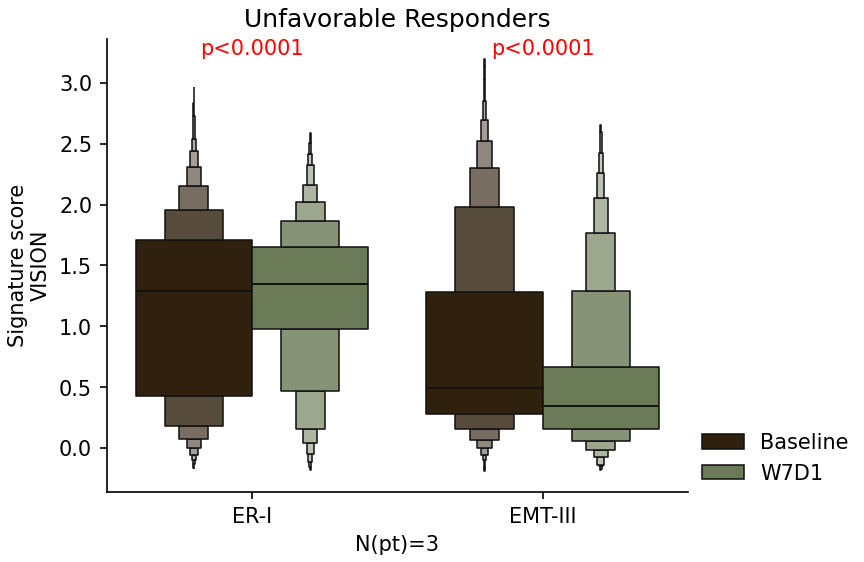

In [38]:
show_mps = ['ER-I','EMT-III']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=COLOR_PAlETTE[x],ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = 'N.S.' 
    elif pvalues[text]<0.0001:
        label = f"p<0.0001"
        c = 'red'
    else:
        label = f"p={pvalues[text]:.3e}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Unfavorable Responders')
# ax.set_xticklabels([])
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);

# Cellular abundance

In [19]:
timepoint='Baseline'
celltype_col='Celltype'
cellstate_col = 'Cellstate'
obs['BestResponseV'] = obs.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
pt_bp_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['BestResponse'].to_dict()
pt_bpV_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['BestResponseV'].to_dict()
pt_rcb_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['RCB'].to_dict()
pt_time_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['Timepoint'].to_dict()

# relative abundance 
ra = (pd.crosstab([obs[celltype_col],obs[cellstate_col]],[obs[celltype_col],obs['Sample_Short']]) / obs.groupby([celltype_col])['Sample_Short'].value_counts()).T

In [20]:
timepoint='Baseline'
# relative abundance 
ra = (pd.crosstab([obs[celltype_col],obs[cellstate_col]],[obs[celltype_col],obs['Sample_Short']]) / obs.groupby([celltype_col])['Sample_Short'].value_counts()).T
dt = ra.loc['Tumor','Tumor']
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
from scipy.stats import ranksums
## order by the z score between R vs NR
##### stats_result on the distribution of relative abundance of each state
stats_dt = dt.apply(lambda v: pd.Series(ranksums(v[v.index.map(pt_bp_map)=='0-I'], 
                                                         v[v.index.map(pt_bp_map)=='II-III']),
                                                index=['statstics','Pvalue'],name=v.name)
                            ,axis=0).T

stats_dt

,statstics,Pvalue
Cellstate,,
Tumor.Cell_Cycle,-0.739600,0.459543
Tumor.EMT-II,-0.832050,0.405381
Tumor.EMT-III,2.311251,0.020819
Tumor.ER-I,-1.941451,0.052204
Tumor.ER-II,-1.016950,0.309177
Tumor.Interferon/MHCII(I),-0.647150,0.517535


Text(0.5, 1.1, 'Malignant cells from baseline samples')

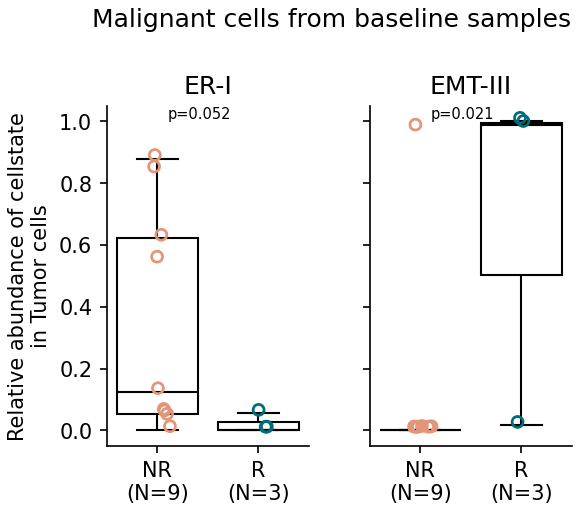

In [41]:
fig,axs = plt.subplots(1,2,figsize=(4,3),sharey=True,dpi=150)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
filled_marker_style = dict(marker='o', linestyle=':', 
                           color='darkgrey',
                           edgecolor='brown')
ax=axs[0]
celltype='Tumor'
cellstate = 'ER-I'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
dt['BestResponse'] = pd.Categorical(dt.index.map(pt_bpV_map),['unfavorable response\n(RCB II-III)','favorable response\n(RCB 0-I)'],ordered=True)
dt['RCB'] =  pd.Categorical(dt.index.map(pt_rcb_map),['0','I','II','III'],ordered=True)
sns.stripplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,hue='BestResponse',palette=COLOR_PAlETTE['BestResponse'], marker="$\circ$", size=10)
sns.boxplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,showfliers=False,linewidth=1,**PROPS)
pvalue = stats_dt.loc[f'{celltype}.{cellstate}','Pvalue']
ax.text(0.3,1,s=f"p={pvalue:.3f}",transform = ax.transAxes,va='top',ha='left',size=7)
ax.set(xlabel='',title=cellstate,ylabel=f'Relative abundance of cellstate\nin {celltype} cells');
ax.spines[['right','top']].set_visible(False)
xticklabels = []
for handle in ax.get_xticklabels():
    rcb = handle.get_text()
    text = {'unfavorable response\n(RCB II-III)':'NR','favorable response\n(RCB 0-I)':'R'}[rcb]
    xticklabels.append(f"{text}\n(N={(dt['BestResponse']==rcb).sum()})")
ax.set_xticklabels(xticklabels)
# ax.legend_.remove()
ax=axs[1]
celltype='Tumor'
cellstate = 'EMT-III'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
dt['BestResponse'] = pd.Categorical(dt.index.map(pt_bpV_map),['unfavorable response\n(RCB II-III)','favorable response\n(RCB 0-I)'],ordered=True)
dt['RCB'] =  pd.Categorical(dt.index.map(pt_rcb_map),['0','I','II','III'],ordered=True)
sns.stripplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,hue='BestResponse',palette=COLOR_PAlETTE['BestResponse'], marker="$\circ$", size=10)
sns.boxplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,showfliers=False,linewidth=1,**PROPS)
pvalue = stats_dt.loc[f'{celltype}.{cellstate}','Pvalue']
ax.text(0.3,1,s=f"p={pvalue:.3f}",transform = ax.transAxes,va='top',ha='left',size=7)
ax.set(xlabel='',title=cellstate,ylabel=f'Relative abundance of cellstate\nin {celltype} cells');
ax.spines[['right','top']].set_visible(False)
xticklabels = []
for handle in ax.get_xticklabels():
    rcb = handle.get_text()
    text = {'unfavorable response\n(RCB II-III)':'NR','favorable response\n(RCB 0-I)':'R'}[rcb]
    xticklabels.append(f"{text}\n(N={(dt['BestResponse']==rcb).sum()})")
ax.set_xticklabels(xticklabels)
# ax.legend(loc=(1.01,0),title='RCB')
plt.subplots_adjust(wspace=.3)
plt.suptitle('Malignant cells from baseline samples',y=1.1)

## External validation- keenan et al., 2021

In [112]:
from utils.misc import mergeRsemGeneOutput
clin = pd.read_excel(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/41467_2021_25769_MOESM5_ESM.xlsx',
                   skiprows=1,sheet_name='Fig 1, 2, 6a-c, Suppl Fig 3, 4',index_col=0)
clin.index=clin.index.map(lambda x:f"P{x}")
# get counts
qced_pts =  pd.read_excel(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/41467_2021_25769_MOESM5_ESM.xlsx',
                   skiprows=1,sheet_name='Suppl Fig 7, 8d-e, 9e-f',index_col=0).columns.str.replace('Patient','P').tolist()
counts,tpm= mergeRsemGeneOutput(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/rsem')
counts.index = counts.index.map(lambda x: '_'.join(x.split('_')[1:])).str.replace('^[0-9]_','')
counts = counts.groupby(level=0).mean().round(0)
counts.columns = counts.columns.map(lambda x: 'P'+str(int(x.split('_')[-1])))

### Signature calculation

In [113]:
keenan = anndata.AnnData(X=counts.T,obs=clin.loc[counts.columns,:])
keenan = keenan[(keenan.obs.Therapy!='Eribulin') &(keenan.obs.Biopsy!='Metastatic'),:]
keenan.obs['Clinical Benefit'] = keenan.obs['Clinical Benefit'].map({1:"CB",0:"NCB"})
n_umi = keenan.X.sum(axis=1)
scaled_counts = (keenan.X.T / n_umi) * np.median(n_umi)
keenan.X = scaled_counts.T
mp_result = sp.ext.VISION(data=keenan,gmt_files=[f"{RESULT_TABLE}/Tumor_Cellstate.gmt"],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/table/Tumor_Cellstate.gmt --h5ad /tmp/tmp838p0_ol/count.h5ad --output_file /tmp/tmp838p0_ol/vision.tsv
$gmt_files
[1] "..//data/table/Tumor_Cellstate.gmt"

$h5ad
[1] "/tmp/tmp838p0_ol/count.h5ad"

$output_file
[1] "/tmp/tmp838p0_ol/vision.tsv"



Loading data from ..//data/table/Tumor_Cellstate.gmt ...

Using 29132/57829 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...



### visualization on boxplot

In [114]:
norm_score = mp_result.rename(columns=MP_anno_map)
norm_score = (norm_score.T - norm_score.mean(axis=1)).T 

In [115]:
norm_score['Clinical Benefit'] = keenan.obs['Clinical Benefit']
norm_score['Response'] = keenan.obs['Response']

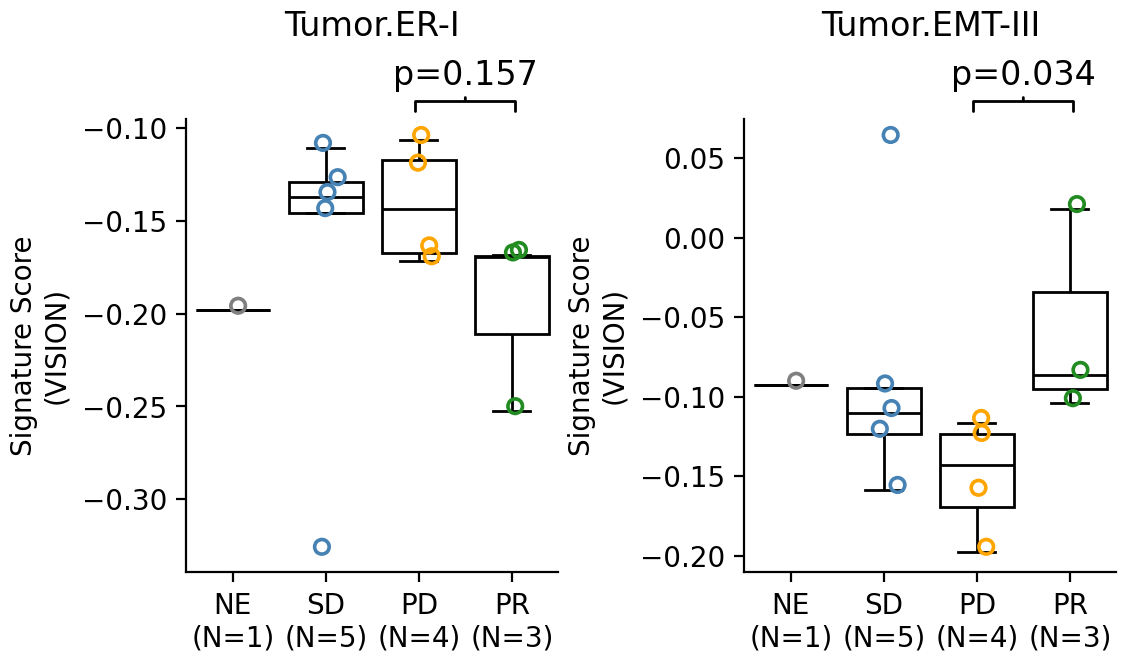

In [117]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['NE','SD','PD','PR']
palette={'NE':'gray','PD':'orange','SD':'steelblue','PR':'forestgreen'}
ylabel='Signature Score\n(VISION)'
x='Response'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Interferon/MHCII(I)'
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['PD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.75, 1.04), xytext=(0.75, 1.06), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.3', lw=1, color='k'))
# ax.annotate('', xy=(0.5, .93), xytext=(0.5, 0.9301), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['PD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.75, 1.04), xytext=(0.75, 1.06), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.3', lw=1, color='k'))
# ax.annotate('', xy=(0.5, 1), xytext=(0.5, 1.001), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)


# Progeny pathway activity

In [76]:
import decoupler as dc
progeny_ref_path = f"{RESULT_TABLE}/progeny_reference.csv"
progeny_path = f"{RESULT_TABLE}/Progeny.xlsx"
pathway_acts = pd.read_excel(progeny_path,sheet_name='Activity',index_col=0)
progeny = pd.read_csv(progeny_ref_path)

degs_dict = {}
degs_path = f"{RESULT_TABLE}/DEGs_Tumor.xlsx"
# for cellstate in  obs.Cellstate.unique():
for cellstate in obs.Cellstate.unique():#['EMT','ER','Interferon','Cell_Cycle']:
    sheet_name = cellstate.replace('/','_')  if '/' in cellstate else cellstate
    degs_dict[cellstate] = pd.read_excel(degs_path,sheet_name=sheet_name,index_col=0)
    

Text(0.5, 0.98, 'Tumor.EMT-III')

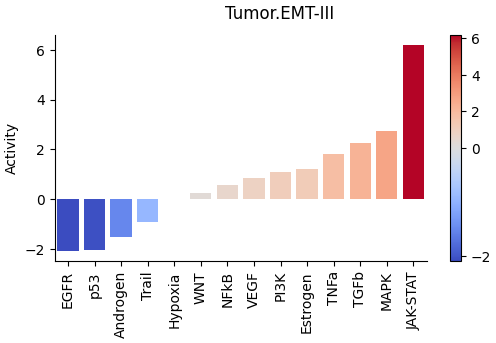

In [78]:
contrast='Tumor.EMT-III'
fig=dc.plot_barplot(
    acts=pathway_acts,
    contrast=contrast,
    top=25,
    vertical=False,
    figsize=(6, 3),
    return_fig=True
)
fig.suptitle(contrast)

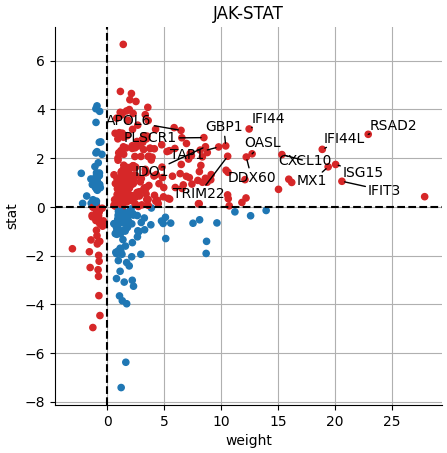

In [79]:
dc.plot_targets(
    data=degs_dict[contrast],
    stat='stat',
    source_name='JAK-STAT',
    net=progeny,
    top=15
)

Text(0.5, 0.98, 'Tumor.ER-I')

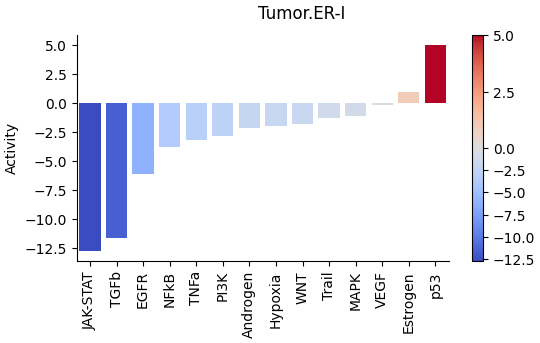

In [80]:
contrast='Tumor.ER-I'
fig=dc.plot_barplot(
    acts=pathway_acts,
    contrast=contrast,
    top=25,
    vertical=False,
    figsize=(6, 3),
    return_fig=True
)
fig.suptitle(contrast)

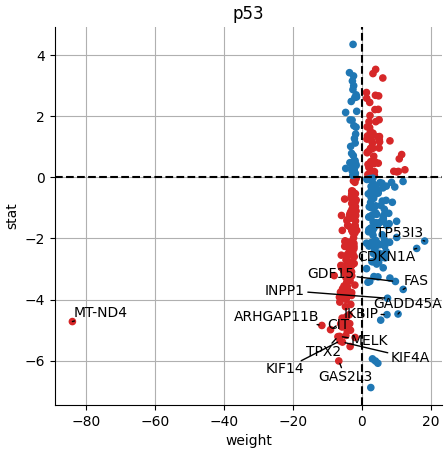

In [81]:
dc.plot_targets(
    data=degs_dict[contrast],
    stat='stat',
    source_name='p53',
    net=progeny,
    top=15
)

# p53 alteration

### Celular abudance

In [28]:
## Mutation data
mutation_data = pd.read_csv(f'{RESULT_TABLE}/somatic_mutation.csv')
mut_tab = (pd.crosstab(mutation_data['sample'],mutation_data['category'])>0).astype(int)

In [56]:
mut_tab.columns[mut_tab.columns.str.startswith('MD')]

Index(['MDGA2', 'MDN1'], dtype='object', name='category')

In [39]:
celltype='Tumor'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,['Tumor.EMT-III','Tumor.ER-I']]
dt[gene] = mut_tab[gene].map({1:'Mut',0:'WT'})
dt['BestResponse'] = dt.index.map(pt_bpV_map)
dt.sort_values('TP53')

Cellstate,Tumor.EMT-III,Tumor.ER-I,TP53,BestResponse
Sample_Short,,,,
P01.T1,0.015500,0.054493,Mut,favorable response\n(RCB 0-I)
P08.T1,0.989664,0.000000,Mut,favorable response\n(RCB 0-I)
P12.T1,0.978005,0.001571,Mut,unfavorable response\n(RCB II-III)
P03.T1,0.000583,0.124745,WT,unfavorable response\n(RCB II-III)
P04.T1,0.001395,0.041628,WT,unfavorable response\n(RCB II-III)
P09.T1,0.000000,0.879715,WT,unfavorable response\n(RCB II-III)
P13.T1,0.000000,0.052550,WT,unfavorable response\n(RCB II-III)
P16.T1,0.000000,0.621434,WT,unfavorable response\n(RCB II-III)
P18.T1,0.002428,0.057579,WT,unfavorable response\n(RCB II-III)


In [29]:
obs.Patient[(obs['BestResponse']=='0-I')&(obs['Timepoint']=='Baseline')].unique()

array(['P01', 'P27', 'P08'], dtype=object)

In [30]:
mut_tab.index[mut_tab['TP53']==0].map(lambda x:x.split('.')[0]).unique()

Index(['P01', 'P03', 'P04', 'P07', 'P08', 'P09', 'P13', 'P15', 'P16', 'P18',
       'P23', 'P24', 'P26', 'P27'],
      dtype='object', name='sample')

### visualization

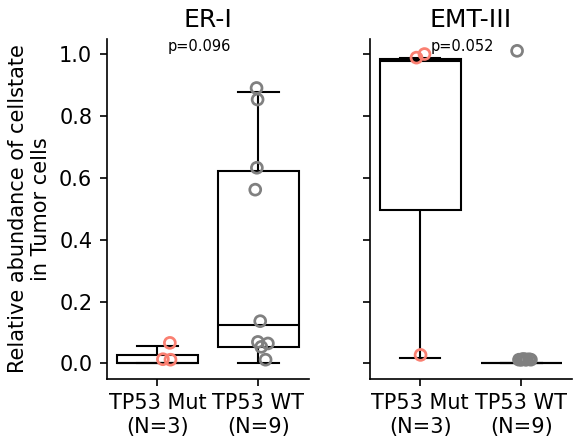

In [40]:
timepoint='Baseline'
gene='TP53'
fig,axs = plt.subplots(1,2,figsize=(4,3),sharey=True,dpi=150)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
filled_marker_style = dict(marker='o', linestyle=':', 
                           color='darkgrey',
                           edgecolor='brown')
ax=axs[0]
celltype='Tumor'
cellstate = 'ER-I'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
dt[gene] = mut_tab[gene].map({1:'Mut',0:'WT'})
dt.dropna(axis=0,inplace=True)# remove samples without WES

sns.stripplot(data=dt,x=gene,y=f'{celltype}.{cellstate}',ax=ax,palette={'Mut':'salmon','WT':'gray'}, marker="$\circ$", ec="face",size=10)
sns.boxplot(data=dt,x=gene,y=f'{celltype}.{cellstate}',ax=ax,showfliers=False,linewidth=1,**PROPS)
_,pvalue = ranksums(dt.loc[dt[gene]=='Mut',f"{celltype}.{cellstate}"],
         dt.loc[dt[gene]=='WT',f"{celltype}.{cellstate}"])
ax.text(0.3,1,s=f"p={pvalue:.3f}",transform = ax.transAxes,va='top',ha='left',size=7)
ax.set(xlabel='',title=cellstate,ylabel=f'Relative abundance of cellstate\nin {celltype} cells');
ax.spines[['right','top']].set_visible(False)
xticklabels = []
for handle in ax.get_xticklabels():
    mut_status = handle.get_text()
    xticklabels.append(f"{gene} {mut_status}\n(N={(dt[gene]==mut_status).sum()})")
ax.set_xticklabels(xticklabels)

ax=axs[1]
celltype='Tumor'
cellstate = 'EMT-III'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
dt[gene] = mut_tab[gene].map({1:'Mut',0:'WT'})
dt.dropna(axis=0,inplace=True)# remove samples without WES

sns.stripplot(data=dt,x=gene,y=f'{celltype}.{cellstate}',ax=ax,palette={'Mut':'salmon','WT':'gray'}, marker="$\circ$", ec="face",size=10)
sns.boxplot(data=dt,x=gene,y=f'{celltype}.{cellstate}',ax=ax,showfliers=False,linewidth=1,**PROPS)
_,pvalue = ranksums(dt.loc[dt[gene]=='Mut',f"{celltype}.{cellstate}"],
         dt.loc[dt[gene]=='WT',f"{celltype}.{cellstate}"])
ax.text(0.3,1,s=f"p={pvalue:.3f}",transform = ax.transAxes,va='top',ha='left',size=7)
ax.set(xlabel='',title=cellstate,ylabel=f'Relative abundance of cellstate\nin {celltype} cells');
ax.spines[['right','top']].set_visible(False)
xticklabels = []
for handle in ax.get_xticklabels():
    mut_status = handle.get_text()
    xticklabels.append(f"{gene} {mut_status}\n(N={(dt[gene]==mut_status).sum()})")
ax.set_xticklabels(xticklabels)
plt.subplots_adjust(wspace=.3)

## External Validation on TCGA

In [119]:
## Data Preperation
# brca = sc.read(f"{EXTERNAL_DATA}/BRCA.h5ad")
# # from cbioportal
# #https://www.cbioportal.org/study/summary?id=brca_tcga_pub2015%2Cbrca_tcga%2Cbrca_tcga_pan_can_atlas_2018%2Cbrca_tcga_pub
# her2_status = pd.read_csv(f'{EXTERNAL_DATA}/IHC-HER2.full.txt',sep='\t')
# er_status = pd.read_csv(f'{EXTERNAL_DATA}/ER_Status_By_IHC.full.txt',sep='\t')
# purity=pd.read_csv('http://api.gdc.cancer.gov/data/4f277128-f793-4354-a13d-30cc7fe9f6b5',sep='\t').set_index('array')['purity']

# brca.obs['HER2-IHC'] = her2_status.set_index('Sample ID')['IHC-HER2']
# brca.obs['ER-IHC'] = er_status.set_index('Sample ID')['ER Status By IHC']
# brca.obs['Tumor_Purity'] = purity
# # brca.obs['Patient'] = brca.obs.index.map(lambda x:'-'.join(x.split('-')[:3]))
# del her2_status,er_status,purity
# ## subset primary hr+ breast cancer
# brca = brca[(brca.obs['sample_type.samples']=='Primary Tumor')&
#             (brca.obs['HER2-IHC'].isin(['Negative', 'Equivocal']))&
#             (brca.obs['ER-IHC']=='Positive')&
#             (brca.obs.Is_Tumor_Biopsy&
#             (~brca.obs['Tumor_Purity'].isna()))&
#             (brca.obs['prior_malignancy.diagnoses']=='no')&
#             (brca.obs['history_of_neoadjuvant_treatment']=='No')&
#             (brca.obs['distant_metastasis_present_ind2']=='NO')&
#             (brca.obs['gender.demographic']=='female'),:] # with purity information

# brca.write(f'{EXTERNAL_DATA}/tcga_primary_hr_pos_brca.h5ad')
brca = sc.read(f'{EXTERNAL_DATA}/tcga_primary_hr_pos_brca.h5ad')
mut = sc.read(f'{EXTERNAL_DATA}/TCGA_BRCA_Mutation.h5ad')
brca.obs =brca.obs.merge(sc.get.obs_df(mut,['TP53']),left_index=True,right_index=True,
                         how='left')

### Calculate MP scores via VISION

In [120]:
n_umi = brca.X.toarray().sum(axis=1)
scaled_counts = (brca.X.toarray().T / n_umi) * np.median(n_umi)
brca.X = scaled_counts.T

In [122]:
mp_result = sp.ext.VISION(data=brca,gmt_files=[f"{RESULT_TABLE}/Tumor_Cellstate.gmt"],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/table/Tumor_Cellstate.gmt --h5ad /tmp/tmpb16x0tcg/count.h5ad --output_file /tmp/tmpb16x0tcg/vision.tsv
$gmt_files
[1] "..//data/table/Tumor_Cellstate.gmt"

$h5ad
[1] "/tmp/tmpb16x0tcg/count.h5ad"

$output_file
[1] "/tmp/tmpb16x0tcg/vision.tsv"



Loading data from ..//data/table/Tumor_Cellstate.gmt ...

Using 54036/58387 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

Evaluating signature-gene importance...



### Normalization

In [ ]:
norm_score = mp_result.copy()
norm_score = (norm_score.T - norm_score.mean(axis=1)).T 
norm_score['TP53'] = brca.obs.loc[norm_score.index,'TP53']
norm_score.dropna(subset=['TP53'],inplace=True)
norm_score['TP53']=norm_score['TP53'].map(lambda x:'Mut' if x > 0 else 'WT')

### Visualization

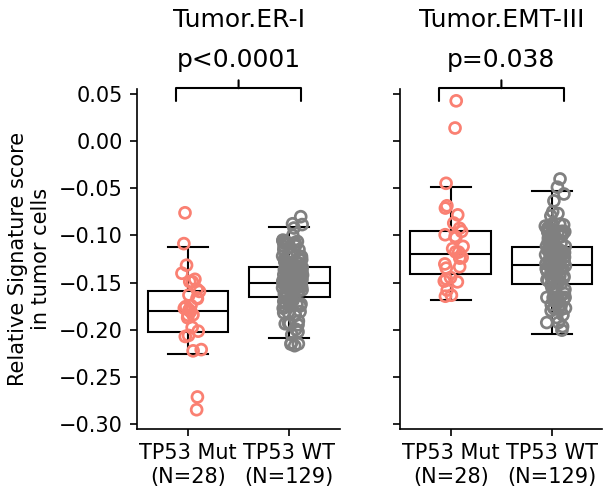

In [123]:


PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['Mut','WT']
palette={'WT':'gray','Mut':'salmon'}
ylabel='Relative Signature score\nin tumor cells'
x='TP53'
fig,axs = plt.subplots(1,2,figsize=(4,3),sharey=True,dpi=150)

## Plot EMT-III
ax=axs[1]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"TP53 {text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

## Plot ER-I
ax=axs[0]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"TP53 {text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}" if pvalue >0.0001 else 'p<0.0001', xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

plt.subplots_adjust(wspace=.3)